<a href="https://colab.research.google.com/github/danon6868/BI-ml-2024/blob/main/lecture_8_pytorch/homework/FC_NN_practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Всем привет! Сегодня вы впервые попробуете написать свою собственную нейронную сеть и попробовать ее обучить. Мы будем работать с картинками, но пока что не совсем тем способом, которым лучше всего это делать, но должно получиться неплохо.

Будем работать с [датасетом](https://github.com/rois-codh/kmnist) `Kuzushiji-MNIST` (`KMNIST`). Это рукописные буквы, изображения имеют размер (28, 28, 1) и разделены на 10 классов, по ссылке можно прочитать подробнее.

In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output

## Загрузка данных

Сейчас мы будем использовать встроенные данные, но в реальности приходится писать свой класс для датасета (Dataset), у которого реализовывать несколько обязательных методов (напр, `__getitem__`), но это обсудим уже потом.

In [4]:
import torchvision
from torchvision.datasets import KMNIST


# Превращает картинки в тензоры
transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor()])

# Загрузим данные (в переменных лежат объекты типа `Dataset`)
# В аргумент `transform` мы передаем необходимые трансформации (ToTensor)
trainset = KMNIST(root="./KMNIST", train=True, download=True, transform=transform)
testset = KMNIST(root="./KMNIST", train=False, download=True, transform=transform)

clear_output()

Определим даталоадеры, они нужны, чтобы реализовывать стохастический градиентный спуск (то есть мы не хотим считывать в оперативную память все картинки сразу, а делать это батчами).

In [10]:
from torch.utils.data import DataLoader


# Можно оставить таким
batch_size = 256

trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True, num_workers=2)
testloader = DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

Подумайте, как может влиять на скорость обучения параметр `batch_size`, почему вы так считаете?

**Ответ:** Больший `batch_size` может позволить получать более стабильное напрвление, однако вместе с этим будет потребляться большее количество памяти, а также возрастает риск переобучения модели.

Посмотрим на какую-нибудь картинку:

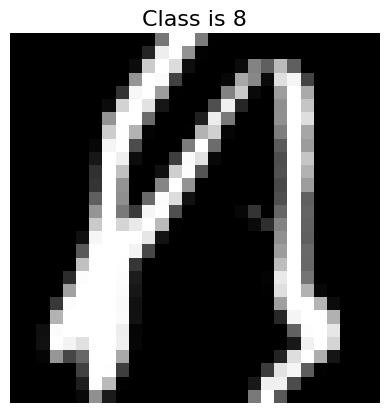

In [11]:
plt.imshow(trainset[0][0].view(28, 28).numpy(), cmap="gray")
plt.axis("off")
plt.title(f"Class is {trainset[0][1]}", fontsize=16);

### Задание 1. Смотрим на картинки

**2** балла

Нарисуйте на одном графике изображения всех 10 классов:

⣿⣿⣿⣿⣿⣿⠿⢋⣥⣴⣶⣶⣶⣬⣙⠻⠟⣋⣭⣭⣭⣭⡙⠻⣿⣿⣿⣿⣿
⣿⣿⣿⣿⡿⢋⣴⣿⣿⠿⢟⣛⣛⣛⠿⢷⡹⣿⣿⣿⣿⣿⣿⣆⠹⣿⣿⣿⣿
⣿⣿⣿⡿⢁⣾⣿⣿⣴⣿⣿⣿⣿⠿⠿⠷⠥⠱⣶⣶⣶⣶⡶⠮⠤⣌⡙⢿⣿
⣿⡿⢛⡁⣾⣿⣿⣿⡿⢟⡫⢕⣪⡭⠥⢭⣭⣉⡂⣉⡒⣤⡭⡉⠩⣥⣰⠂⠹
⡟⢠⣿⣱⣿⣿⣿⣏⣛⢲⣾⣿⠃⠄⠐⠈⣿⣿⣿⣿⣿⣿⠄⠁⠃⢸⣿⣿⡧
⢠⣿⣿⣿⣿⣿⣿⣿⣿⣇⣊⠙⠳⠤⠤⠾⣟⠛⠍⣹⣛⣛⣢⣀⣠⣛⡯⢉⣰
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡶⠶⢒⣠⣼⣿⣿⣛⠻⠛⢛⣛⠉⣴⣿⣿
⣿⣿⣿⣿⣿⣿⣿⡿⢛⡛⢿⣿⣿⣶⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⡈⢿⣿
⣿⣿⣿⣿⣿⣿⣿⠸⣿⡻⢷⣍⣛⠻⠿⠿⣿⣿⣿⣿⣿⣿⣿⣿⣿⠿⢇⡘⣿
⣿⣿⣿⣿⣿⣿⣿⣷⣝⠻⠶⣬⣍⣛⣛⠓⠶⠶⠶⠤⠬⠭⠤⠶⠶⠞⠛⣡⣿
⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣷⣶⣬⣭⣍⣙⣛⣛⣛⠛⠛⠛⠿⠿⠿⠛⣠⣿⣿
⣦⣈⠉⢛⠻⠿⠿⢿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⡿⠿⠛⣁⣴⣾⣿⣿⣿⣿
⣿⣿⣿⣶⣮⣭⣁⣒⣒⣒⠂⠠⠬⠭⠭⠭⢀⣀⣠⣄⡘⠿⣿⣿⣿⣿⣿⣿⣿
⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣿⣦⡈⢿⣿⣿⣿⣿⣿





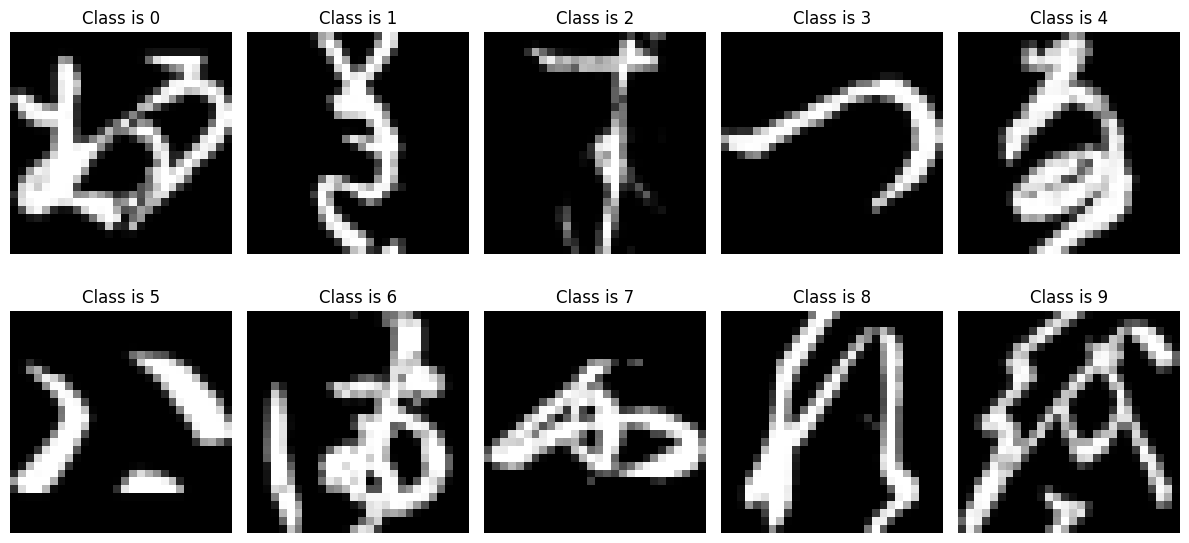

In [16]:
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i in range(10):
    img = next(img for img, label in trainset if label == i)
    ax = axes[i // 5, i % 5]
    ax.imshow(img[0].view(28, 28).numpy(), cmap="gray")
    ax.set_title(f"Class is {i}", fontsize=12)
    ax.axis("off")

plt.tight_layout()
plt.show()

### Задание 2. Строим свой первый MLP

**4** балла

MLP (multilayer perceptron) или нейронная сеть из полносвязных (линейных) слоев, это мы уже знаем.

Опишите структуру сети: 3 полносвязных слоя + функции активации на ваш выбор. **Подумайте** про активацию после последнего слоя!

Сеть на выходе 1 слоя должна иметь 256 признаков, на выходе из 2 128 признаков, на выходе из последнего столько, сколько у вас классов.

https://pytorch.org/docs/stable/nn.html?highlight=activation#non-linear-activations-weighted-sum-nonlinearity

In [21]:
import torch.nn as nn

class FCNet(nn.Module):
    def __init__(self):
        super().__init__() #  это надо помнить!
        ## YOUR CODE HERE
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.activation1 = nn.ReLU()
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.activation2 = nn.ReLU()
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.output_activation = nn.Softmax(dim=1)


    def forward(self, x):  # Forward вызывается внутри метода __call__ родительского класса
        ## x -> тензор размерности (BATCH_SIZE, N_CHANNELS, WIDTH, HEIGHT)
        ## надо подумать над тем, что у нас полносвязные слои принимают векторы

        ## YOUR CODE HERE
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.output_activation(x)

        return x

Сколько обучаемых параметров у вашей модели (весов и смещений)?

**Ответ:**

In [23]:
model = FCNet()

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Обучаемые параметры в модели FCNet:", total_params)

Обучаемые параметры в модели FCNet: 235146


### Задание 3. Напишите код для обучения модели

**5** баллов

Можно (и нужно) подглядывать в код семинара по пайторчу. Вам нужно создать модель, определить функцию потерь и оптимизатор (начнем с `SGD`). Дальше нужно обучать модель, при помощи тренировочного `Dataloader'a` и считать лосс на тренировочном и тестовом `Dataloader'ах`.

Напишем функцию для рассчета `accuracy`:

In [24]:
def get_accuracy(model, dataloader):
    """
    model - обученная нейронная сеть
    dataloader - даталоадер, на котором вы хотите посчитать accuracy
    """
    correct = 0
    total = 0
    with torch.no_grad(): # Тензоры внутри этого блока будут иметь requires_grad=False
        for images, labels in dataloader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total

    return accuracy

#### Основной цикл обучения

Этот код можно (и зачастую нужно) выносить в отдельную функцию, но пока что можете это не делать, все по желанию)

In [25]:
# Создадим объект модели
fc_net = FCNet()
# Определим функцию потерь
loss_function = nn.CrossEntropyLoss()
# Создадим оптимизатор для нашей сети
lr = 0.001 # скорость обучения
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

Напишите цикл обучения. Для начала хватит 10 эпох. Какое значение `accuracy` на тестовой выборке удалось получить?

In [27]:
%%time
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

/home/dorzhi/BI/ML/BI-ml-2024/.conda/lib/python3.11/site-packages/torch/autograd/__init__.py:266: UserWarning: CUDA initialization: Unexpected error from cudaGetDeviceCount(). Did you run some cuda functions before calling NumCudaDevices() that might have already set an error? Error 804: forward compatibility was attempted on non supported HW (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch=1 loss=1.8516
Epoch=2 loss=1.6708
Epoch=3 loss=1.6485
Epoch=4 loss=1.6364
Epoch=5 loss=1.6279
Epoch=6 loss=1.6205
Epoch=7 loss=1.6139
Epoch=8 loss=1.6083
Epoch=9 loss=1.6025
Epoch=10 loss=1.5973
CPU times: user 1min 48s, sys: 2.88 s, total: 1min 51s
Wall time: 23 s


In [28]:
get_accuracy(fc_net, testloader)

0.71

### Задание 4. Изучение влияния нормализации

**3** балла

Вы могли заметить, что мы забыли провести нормализацию наших данных, а для нейронных сетей это может быть очень критично.

Нормализуйте данные.

* Подсчитайте среднее значение и стандартное отклонение интенсивности пикселей для всех тренировочных данных
* Нормализуйте данные с использованием этих параметров (используйте трансформацию `Normalize`)


Оцените влияние нормировки данных.

In [31]:
mean = torch.stack([image.mean(dim=(1, 2)) for image, _ in trainset]).mean(dim=0)
std = torch.stack([image.std(dim=(1, 2)) for image, _ in trainset]).mean(dim=0)
print(mean, std)

transform_with_norm = torchvision.transforms.Compose([
                torchvision.transforms.ToTensor(),
                torchvision.transforms.Normalize(mean, std)
            ])

trainset.transform = transform_with_norm
testset.transform = transform_with_norm

tensor([0.1918]) tensor([0.3385])


In [32]:
fc_net = FCNet()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(fc_net.parameters(), lr=3e-4)

In [33]:
n_epochs = 10
loss_history = []

## YOUR CODE HERE
for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = fc_net(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.7669
Epoch=2 loss=1.6345
Epoch=3 loss=1.6074
Epoch=4 loss=1.5835
Epoch=5 loss=1.5692
Epoch=6 loss=1.5580
Epoch=7 loss=1.5507
Epoch=8 loss=1.5449
Epoch=9 loss=1.5397
Epoch=10 loss=1.5358


In [34]:
get_accuracy(fc_net, testloader)

0.8025

Как изменилась `accuracy` после нормализации?

Accuracy увеличилось почти на 0.1.


### Задание 5. Изучение влияния функции активации

**3** балла

Исследуйте влияние функций активации на скорость обучения и точность предсказаний модели.

Используйте три функции:

* [Sigmoid](https://pytorch.org/docs/stable/nn.functional.html#sigmoid)
* [GELU](https://pytorch.org/docs/stable/nn.functional.html#gelu)
* [Tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html#torch.nn.Tanh)

In [35]:
class FCNetSigmoid(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.activation1 = nn.Sigmoid()
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.activation2 = nn.Sigmoid()
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.output_activation(x)

        return x

In [39]:
class FCNetGelu(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.activation1 = nn.GELU()
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.activation2 = nn.GELU()
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.output_activation(x)

        return x

In [38]:
class FCNetTanh(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.activation1 = nn.Tanh()
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.activation2 = nn.Tanh()
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.output_activation(x)

        return x

In [45]:
n_epochs = 10
loss_history_sigmoid = []
loss_history_gelu = []
loss_history_tanh = []

## YOUR CODE HERE

model_sigmoid = FCNetSigmoid()
model_gelu = FCNetGelu()
model_tanh = FCNetTanh()

optimizer_sigmoid = torch.optim.Adam(model_sigmoid.parameters(), lr=3e-4)
optimizer_gelu = torch.optim.Adam(model_gelu.parameters(), lr=3e-4)
optimizer_tanh = torch.optim.Adam(model_tanh.parameters(), lr=3e-4)

for epoch in range(n_epochs):
    epoch_loss_sigmoid = 0
    epoch_loss_gelu = 0
    epoch_loss_tanh = 0

    for images, labels in trainloader:
        optimizer_sigmoid.zero_grad()
        optimizer_gelu.zero_grad()
        optimizer_tanh.zero_grad()

        outputs_sigmoid = model_sigmoid(images)
        outputs_gelu = model_gelu(images)
        outputs_tanh = model_tanh(images)

        loss_sigmoid = loss_function(outputs_sigmoid, labels)
        loss_gelu = loss_function(outputs_gelu, labels)
        loss_tanh = loss_function(outputs_tanh, labels)

        loss_sigmoid.backward()
        loss_gelu.backward()
        loss_tanh.backward()

        optimizer_sigmoid.step()
        optimizer_gelu.step()
        optimizer_tanh.step()

        epoch_loss_sigmoid += loss_sigmoid.item()
        epoch_loss_gelu += loss_gelu.item()
        epoch_loss_tanh += loss_tanh.item()

    loss_history_sigmoid.append(epoch_loss_sigmoid / len(trainloader))
    loss_history_gelu.append(epoch_loss_gelu / len(trainloader))
    loss_history_tanh.append(epoch_loss_tanh / len(trainloader))

    print(f"Epoch={epoch+1} Sigmoid loss={loss_history_sigmoid[epoch]:.4f} GELU loss={loss_history_gelu[epoch]:.4f} Tanh loss={loss_history_tanh[epoch]:.4f}")

Epoch=1 Sigmoid loss=2.1142 GELU loss=1.7535 Tanh loss=1.7981
Epoch=2 Sigmoid loss=1.8558 GELU loss=1.6288 Tanh loss=1.6328
Epoch=3 Sigmoid loss=1.7075 GELU loss=1.5954 Tanh loss=1.5993
Epoch=4 Sigmoid loss=1.6603 GELU loss=1.5760 Tanh loss=1.5727
Epoch=5 Sigmoid loss=1.6314 GELU loss=1.5620 Tanh loss=1.5451
Epoch=6 Sigmoid loss=1.6159 GELU loss=1.5508 Tanh loss=1.5293
Epoch=7 Sigmoid loss=1.6046 GELU loss=1.5394 Tanh loss=1.5185
Epoch=8 Sigmoid loss=1.5952 GELU loss=1.5324 Tanh loss=1.5109
Epoch=9 Sigmoid loss=1.5874 GELU loss=1.5273 Tanh loss=1.5048
Epoch=10 Sigmoid loss=1.5801 GELU loss=1.5228 Tanh loss=1.4956


In [50]:
print('Sigmoid accuracy:', get_accuracy(model_sigmoid, testloader))
print('GELU accuracy:', get_accuracy(model_gelu, testloader))
print('Tanh accuracy:', get_accuracy(model_tanh, testloader))

Sigmoid accuracy: 0.7507
GELU accuracy: 0.8191
Tanh accuracy: 0.882


С использованием какой функции активации удалось досчить наибольшей `accuracy`?

Наибольшее значение было достигнуто с использованием модели Tanh.

### Задание 6. Другие оптимизаторы

**4** балла

Исследуйте влияние оптимизаторов на скорость обучения и точность предсказаний модели.

Попробуйте следующие:

* [Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam)
* [RMSprop](https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html#torch.optim.RMSprop)
* [Adagrad](https://pytorch.org/docs/stable/generated/torch.optim.Adagrad.html#torch.optim.Adagrad)

Вам нужно снова обучить 3 модели и сравнить их перформанс (функцию активации используйте ту, которая показала себя лучше всего).

In [51]:
model_adam = FCNetTanh()
model_rmsprop = FCNetTanh()
model_adagrad = FCNetTanh()

optimizer_adam = torch.optim.Adam(model_adam.parameters(), lr=3e-4)
optimizer_rmsprop = torch.optim.RMSprop(model_rmsprop.parameters(), lr=3e-4)
optimizer_adagrad = torch.optim.Adagrad(model_adagrad.parameters(), lr=3e-4)

n_epochs = 10
loss_history_adam = []
loss_history_rmsprop = []
loss_history_adagrad = []

for epoch in range(n_epochs):
    epoch_loss_adam = 0
    epoch_loss_rmsprop = 0
    epoch_loss_adagrad = 0

    for images, labels in trainloader:
        optimizer_adam.zero_grad()
        optimizer_rmsprop.zero_grad()
        optimizer_adagrad.zero_grad()

        outputs_adam = model_adam(images)
        outputs_rmsprop = model_rmsprop(images)
        outputs_adagrad = model_adagrad(images)

        loss_adam = loss_function(outputs_adam, labels)
        loss_rmsprop = loss_function(outputs_rmsprop, labels)
        loss_adagrad = loss_function(outputs_adagrad, labels)

        loss_adam.backward()
        loss_rmsprop.backward()
        loss_adagrad.backward()

        optimizer_adam.step()
        optimizer_rmsprop.step()
        optimizer_adagrad.step()

        epoch_loss_adam += loss_adam.item()
        epoch_loss_rmsprop += loss_rmsprop.item()
        epoch_loss_adagrad += loss_adagrad.item()

    loss_history_adam.append(epoch_loss_adam / len(trainloader))
    loss_history_rmsprop.append(epoch_loss_rmsprop / len(trainloader))
    loss_history_adagrad.append(epoch_loss_adagrad / len(trainloader))

    print(f"Epoch={epoch+1} Adam loss={loss_history_adam[epoch]:.4f} RMSprop loss={loss_history_rmsprop[epoch]:.4f} Adagrad loss={loss_history_adagrad[epoch]:.4f}")

Epoch=1 Adam loss=1.7840 RMSprop loss=1.6871 Adagrad loss=2.0655
Epoch=2 Adam loss=1.6259 RMSprop loss=1.5952 Adagrad loss=1.9087
Epoch=3 Adam loss=1.5827 RMSprop loss=1.5648 Adagrad loss=1.8480
Epoch=4 Adam loss=1.5573 RMSprop loss=1.5452 Adagrad loss=1.8140
Epoch=5 Adam loss=1.5356 RMSprop loss=1.5301 Adagrad loss=1.7918
Epoch=6 Adam loss=1.5195 RMSprop loss=1.5145 Adagrad loss=1.7761
Epoch=7 Adam loss=1.5083 RMSprop loss=1.5044 Adagrad loss=1.7642
Epoch=8 Adam loss=1.5003 RMSprop loss=1.4971 Adagrad loss=1.7544
Epoch=9 Adam loss=1.4943 RMSprop loss=1.4915 Adagrad loss=1.7463
Epoch=10 Adam loss=1.4901 RMSprop loss=1.4875 Adagrad loss=1.7397


In [52]:
print('Adam accuracy:', get_accuracy(model_adam, testloader))
print('RMSprop accuracy:', get_accuracy(model_rmsprop, testloader))
print('Adagrad accuracy:', get_accuracy(model_adagrad, testloader))

Adam accuracy: 0.8849
RMSprop accuracy: 0.8843
Adagrad accuracy: 0.6096


Оптимизатор Adam показал себя, как самый лучший.

### Задание 7. Реализация ReLU

**4** балла

Самостоятельно реализуйте функцию активации ReLU.
Замените в уже обученной модели функцию активации на вашу. Убедитесь что ничего не изменилась.

In [67]:
def custom_relu(x):
    return torch.where(x < 0, torch.tensor(0.0), x)

class CustomReLU(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(in_features=28*28, out_features=256)
        self.activation1 = custom_relu
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.activation2 = custom_relu
        self.fc3 = nn.Linear(in_features=128, out_features=10)
        self.output_activation = nn.Softmax(dim=1)

    def forward(self, x):
        # YOUR CODE HERE
        # если элемент x < 0, то 0, если >= 0, то x
        x = x.view(-1, 28*28)
        x = self.fc1(x)
        x = self.activation1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.fc3(x)
        x = self.output_activation(x)

        return x

Заново обучите модель и проверьте правильность реализации `CustomReLU`.

In [68]:
model_custom_relu = CustomReLU()
loss_function = nn.CrossEntropyLoss()
lr = 0.001
optimizer = torch.optim.Adam(model_custom_relu.parameters(), lr=3e-4)

n_epochs = 10
loss_history = []

for epoch in range(n_epochs):
    epoch_loss = 0
    for images, labels in trainloader: 
        optimizer.zero_grad() 
        outputs = model_custom_relu(images) 
        loss = loss_function(outputs, labels) 
        loss.backward() 
        optimizer.step()

        epoch_loss += loss.item()

    loss_history.append(epoch_loss/len(trainloader))

    print(f"Epoch={epoch+1} loss={loss_history[epoch]:.4f}")

Epoch=1 loss=1.7816
Epoch=2 loss=1.6257
Epoch=3 loss=1.5936
Epoch=4 loss=1.5744
Epoch=5 loss=1.5603
Epoch=6 loss=1.5502
Epoch=7 loss=1.5422
Epoch=8 loss=1.5366
Epoch=9 loss=1.5316
Epoch=10 loss=1.5276


In [69]:
get_accuracy(model_custom_relu, testloader)

0.8137

### Задание 8. Генерация картинок

**3** балла

Придумайте 3 предложения и сгенерируйте при помощи них 3 картинки, используя телеграм бота [ruDALLE](https://t.me/sber_rudalle_xl_bot). Прикрепите сюда ваши картины.